<a href="https://colab.research.google.com/github/Akons97/DeepNoiseSuppression/blob/main/RNNdenoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import decimal

import numpy
import math
import logging


def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))


def rolling_window(a, window, step=1):
    # http://ellisvalentiner.com/post/2017-03-21-np-strides-trick
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return numpy.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step]


def framesig(sig, frame_len, frame_step, winfunc=lambda x: numpy.ones((x,)), stride_trick=True):
    """Frame a signal into overlapping frames.

    :param sig: the audio signal to frame.
    :param frame_len: length of each frame measured in samples.
    :param frame_step: number of samples after the start of the previous frame that the next frame should begin.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied.
    :param stride_trick: use stride trick to compute the rolling window and window multiplication faster
    :returns: an array of frames. Size is NUMFRAMES by frame_len.
    """
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step))

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = numpy.zeros((padlen - slen,))
    padsignal = numpy.concatenate((sig, zeros))
    if stride_trick:
        win = winfunc(frame_len)
        frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    else:
        indices = numpy.tile(numpy.arange(0, frame_len), (numframes, 1)) + numpy.tile(
            numpy.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
        indices = numpy.array(indices, dtype=numpy.int32)
        frames = padsignal[indices]
        win = numpy.tile(winfunc(frame_len), (numframes, 1))

    return frames * win


def deframesig(frames, siglen, frame_len, frame_step, winfunc=lambda x: numpy.ones((x,))):
    """Does overlap-add procedure to undo the action of framesig.

    :param frames: the array of frames.
    :param siglen: the length of the desired signal, use 0 if unknown. Output will be truncated to siglen samples.
    :param frame_len: length of each frame measured in samples.
    :param frame_step: number of samples after the start of the previous frame that the next frame should begin.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied.
    :returns: a 1-D signal.
    """
    frame_len = round_half_up(frame_len)
    frame_step = round_half_up(frame_step)
    numframes = numpy.shape(frames)[0]
    assert numpy.shape(frames)[1] == frame_len, '"frames" matrix is wrong size, 2nd dim is not equal to frame_len'

    indices = numpy.tile(numpy.arange(0, frame_len), (numframes, 1)) + numpy.tile(
        numpy.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
    indices = numpy.array(indices, dtype=numpy.int32)
    padlen = (numframes - 1) * frame_step + frame_len

    if siglen <= 0: siglen = padlen

    rec_signal = numpy.zeros((padlen,))
    window_correction = numpy.zeros((padlen,))
    win = winfunc(frame_len)

    for i in range(0, numframes):
        window_correction[indices[i, :]] = window_correction[
                                               indices[i, :]] + win + 1e-15  # add a little bit so it is never zero
        rec_signal[indices[i, :]] = rec_signal[indices[i, :]] + frames[i, :]

    rec_signal = rec_signal / window_correction
    return rec_signal[0:siglen]


def magspec(frames, NFFT):
    """Compute the magnitude spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).

    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the magnitude spectrum of the corresponding frame.
    """
    if numpy.shape(frames)[1] > NFFT:
        logging.warn(
            'frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.',
            numpy.shape(frames)[1], NFFT)
    complex_spec = numpy.fft.rfft(frames, NFFT)
    return numpy.absolute(complex_spec)


def powspec(frames, NFFT):
    """Compute the power spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).

    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the power spectrum of the corresponding frame.
    """
    return 1.0 / NFFT * numpy.square(magspec(frames, NFFT))
    #return 1.0 / NFFT * magspec(frames, NFFT)


def logpowspec(frames, NFFT, norm=1):
    """Compute the log power spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).

    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :param norm: If norm=1, the log power spectrum is normalised so that the max value (across all frames) is 0.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the log power spectrum of the corresponding frame.
    """
    ps = powspec(frames, NFFT);
    ps[ps <= 1e-30] = 1e-30
    lps = 10 * numpy.log10(ps)
    if norm:
        return lps - numpy.max(lps)
    else:
        return lps


def preemphasis(signal, coeff=0.95):
    """perform preemphasis on the input signal.

    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is no filter, default is 0.95.
    :returns: the filtered signal.
    """
    return numpy.append(signal[0], signal[1:] - coeff * signal[:-1])


In [ ]:
# calculate filterbank features. Provides e.g. fbank and mfcc features for use in ASR applications
# Author: James Lyons 2012
from __future__ import division
import numpy
from scipy.fftpack import dct

def calculate_nfft(samplerate, winlen):
    """Calculates the FFT size as a power of two greater than or equal to
    the number of samples in a single window length.
    
    Having an FFT less than the window length loses precision by dropping
    many of the samples; a longer FFT than the window allows zero-padding
    of the FFT buffer which is neutral in terms of frequency domain conversion.

    :param samplerate: The sample rate of the signal we are working with, in Hz.
    :param winlen: The length of the analysis window in seconds.
    """
    window_length_samples = winlen * samplerate
    nfft = 1
    while nfft < window_length_samples:
        nfft *= 2
    return nfft

def mfcc(signal,samplerate=16000,winlen=0.025,winstep=0.01,numcep=13,
         nfilt=26,nfft=None,lowfreq=0,highfreq=None,preemph=0.97,ceplifter=22,appendEnergy=True,
         winfunc=lambda x:numpy.ones((x,))):
    """Compute MFCC features from an audio signal.

    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param numcep: the number of cepstrum to return, default 13
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is None, which uses the calculate_nfft function to choose the smallest size that does not drop sample data.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
    :param appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by numcep) containing features. Each row holds 1 feature vector.
    """
    nfft = nfft or calculate_nfft(samplerate, winlen)
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph,winfunc)
    feat = numpy.log(feat)
    feat = dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
    feat = lifter(feat,ceplifter)
    if appendEnergy: feat[:,0] = numpy.log(energy) # replace first cepstral coefficient with log of frame energy
    return feat

def fbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
          nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
          winfunc=lambda x:numpy.ones((x,))):
    """Compute Mel-filterbank energy features from an audio signal.

    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: 2 values. The first is a numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector. The
        second return value is the energy in each frame (total energy, unwindowed)
    """
    highfreq= highfreq or samplerate/2
    signal = preemphasis(signal,preemph)
    frames = framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = powspec(frames,nfft)
    energy = numpy.sum(pspec,1) # this stores the total energy in each frame
    energy = numpy.where(energy == 0,numpy.finfo(float).eps,energy) # if energy is zero, we get problems with log

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    feat = numpy.where(feat == 0,numpy.finfo(float).eps,feat) # if feat is zero, we get problems with log
    return feat,energy

def logfbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
             nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
             winfunc=lambda x:numpy.ones((x,))):
    """Compute log Mel-filterbank energy features from an audio signal.

    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph,winfunc)
    return numpy.log(feat)

def ssc(signal,samplerate=16000,winlen=0.025,winstep=0.01,
        nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
        winfunc=lambda x:numpy.ones((x,))):
    """Compute Spectral Subband Centroid features from an audio signal.

    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: A numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    highfreq= highfreq or samplerate/2
    signal = preemphasis(signal,preemph)
    frames = framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = powspec(frames,nfft)
    pspec = numpy.where(pspec == 0,numpy.finfo(float).eps,pspec) # if things are all zeros we get problems

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    R = numpy.tile(numpy.linspace(1,samplerate/2,numpy.size(pspec,1)),(numpy.size(pspec,0),1))

    return numpy.dot(pspec*R,fb.T) / feat

def hz2mel(hz):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * numpy.log10(1+hz/700.)

def mel2hz(mel):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)

    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the sample rate of the signal we are working with, in Hz. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = numpy.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = numpy.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = numpy.zeros([nfilt,nfft//2+1])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def lifter(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs.

    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes,ncoeff = numpy.shape(cepstra)
        n = numpy.arange(ncoeff)
        lift = 1 + (L/2.)*numpy.sin(numpy.pi*n/L)
        return lift*cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra

def delta(feat, N):
    """Compute delta features from a feature vector sequence.

    :param feat: A numpy array of size (NUMFRAMES by number of features) containing features. Each row holds 1 feature vector.
    :param N: For each frame, calculate delta features based on preceding and following N frames
    :returns: A numpy array of size (NUMFRAMES by number of features) containing delta features. Each row holds 1 delta feature vector.
    """
    if N < 1:
        raise ValueError('N must be an integer >= 1')
    NUMFRAMES = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N+1)])
    delta_feat = numpy.empty_like(feat)
    padded = numpy.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
    for t in range(NUMFRAMES):
        delta_feat[t] = numpy.dot(numpy.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat


In [ ]:
def get_band_filter_coeff(samplerate, f0, Q=1.0):
    """
    Bandpass filter based on BLT: Cookbook formulae for audio EQ biquad filter coefficients
    https://gist.github.com/RyanMarcus/d3386baa6b4cb1ac47f4#file-gistfile1-txt
    """
    w0 = 2 * np.pi * f0 / samplerate
    alpha = np.sin(w0) / (2 * Q)
    a = np.zeros(3)
    b = np.zeros(3)
    b[0] = Q*alpha
    b[1] = 0
    b[2] = -Q*alpha
    a[0] = 1 + alpha
    a[1] = -2*np.cos(w0)
    a[2] = 1-alpha
    return  b, a

def iir_design_first_order(band_frequency, samplerate, normalize=True): # the ban frequency is the middel fre
    b = []
    a = []
    for i in range(len(band_frequency)):
        b_, a_ = get_band_filter_coeff(samplerate, band_frequency[i])
        if(normalize):
            b_ = b_/a_[0]           # unified
            a_[1:] = a_[1:]/a_[0]
            a_[0] = 1
        b.append(b_)
        a.append(a_)
    return b, a
    # Ref implementation:
    # b, a = set_gains(b_in, a_in, alpha, gains[0])
    # i = 0
    # g = 0
    # for n in range(2, len(x)):
    #     y[n] = b[0] * x[n] + b[1] * x[n - 1] + b[2] * x[n - 2] - a[1]* y[n - 1] - a[2] * y[n - 2]
    #     if (n % step == 0 and i < len(gains)-1):
    #         i += 1
    #         g = gains[i] * 0.4 + g*0.6
    #         b, a = set_gains(b_in, a_in, alpha, g)
    # return y

def generate_filter_header(b, a, order, filename='equalizer_coeff.h'):
    def array2str(data):
        s = np.array2string(np.array(data).flatten(), separator=',')
        return s.replace("\n", "").replace("\r", "").replace(' ', '').replace(',', ', ').replace('[', '{').replace(']', '}')
    with open(filename, 'w') as file:
        file.write("\n#define NUM_FILTER " + str(len(b)) + '\n')
        file.write("\n#define NUM_ORDER " +  str(order) + '\n')
        file.write("\n#define NUM_COEFF_PAIR " + str(order*2+1) + '\n')
        file.write("\n#define FILTER_COEFF_A " + array2str(a) + "\n")
        file.write("\n#define FILTER_COEFF_B " + array2str(b) + "\n")

def iir_design(band_frequency, samplerate, order=1): # the ban frequency is the middel fre
    b = []
    a = []
    fre = band_frequency / (samplerate/2)
    for i in range(1, len(band_frequency)-1):
        b_, a_ = signal.iirfilter(order, [fre[i] - (fre[i]-fre[i-1])/2, fre[i]+ (fre[i+1]-fre[i])/2],
                                  btype='bandpass', output='ba')
        # b_, a_ = signal.iirfilter(order, [fre[i-1], fre[i+1]-0.001],
        #                            btype='bandpass', output='ba')
        # b_, a_ = signal.cheby1(order, 1, [fre[i] - (fre[i]-fre[i-1])/2, fre[i]+ (fre[i+1]-fre[i])/2],
        #                           btype='bandpass', output='ba')
        b.append(b_)
        a.append(a_)
    return b, a

def fir_design(band_frequency, samplerate, order=51):
    from scipy import signal
    b = []
    fre = band_frequency / (samplerate/2)
    for i in range(1, len(band_frequency)-1):
        b.append(signal.firwin(order, [fre[i] - (fre[i]-fre[i-1])/2, fre[i]+ (fre[i+1]-fre[i])/2], pass_zero='bandpass'))
    return b

def get_mel_scale(nfilt=20, samplerate=16000, lowfreq=20, highfreq=8000):
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"
    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    return melpoints

def bandpass_filter_fir(sig, b_in, a_in, step, gains):
    from scipy import signal
    x = sig
    y = np.zeros(len(x))
    state = np.zeros(len(b_in)-1)
    g=0
    for n in range(0, len(gains)):
        g = max(0.8*g, gains[n])    # pre RNNoise paper https://arxiv.org/pdf/1709.08243.pdf
        b = b_in * g
        filtered, state = signal.lfilter(b, 1, x[n*step: min((n+1)*step, len(x))], zi=state)
        y[n*step: min((n+1)*step, len(x))] = filtered
    return y

def bandpass_filter_iir(sig, b_in, a_in, step, gains):
    from scipy import signal
    x = sig
    y = np.zeros(len(x))
    state = np.zeros(len(b_in)-1)
    g=0
    for n in range(0, len(gains)):
        g = max(0.6*g, gains[n])    # r=0.6 pre RNNoise paper https://arxiv.org/pdf/1709.08243.pdf
        b = b_in*g
        a = a_in
        filtered, state = signal.lfilter(b, a, x[n*step: min((n+1)*step, len(x))], zi=state)
        y[n*step: min((n+1)*step, len(x))] = filtered
    return y


def plot_frequency_respond(b, a=None, fs=16000):
    a = a if len(a) == len(b)  else np.ones(len(b))
    for i in range(len(b)):
        w, h = signal.freqz(b[i], a[i])
        plt.plot(w*0.15915494327*fs, 20 * np.log10(np.maximum(abs(h), 1e-5)), 'b')
    plt.title('Digital filter frequency response')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [Hz]')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


mfcc max: 24.232359 mfcc min: -36.04365
mfcc diff max: 30.337692 mfcc diff min: -31.666931
timestamp 2048 num of data 2813
band frequency [ 102.38738937  194.20211475  296.52291726  410.55197503  537.62902779
  679.24711752  837.07013045 1012.95234618 1208.96022385 1427.39668114
 1670.82815158 1942.11473777 2244.44381507 2581.36748045 2956.84428639
 3375.28575041 3841.6081864  4361.29046698 4940.43839534 5585.85644297
 6305.12769616 7106.70295045]
filtering with frequency:  102.38738937023022
filtering with frequency:  194.20211475051894
filtering with frequency:  296.52291725556677
filtering with frequency:  410.55197503375035
filtering with frequency:  537.6290277878946
filtering with frequency:  679.2471175215904
filtering with frequency:  837.0701304507837
filtering with frequency:  1012.9523461824498
filtering with frequency:  1208.9602238457596
filtering with frequency:  1427.3966811433463
filtering with frequency:  1670.8281515798647
filtering with frequency:  1942.1147377661334

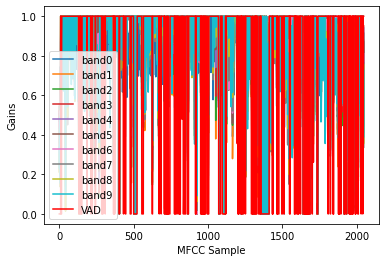

In [ ]:

import matplotlib.pyplot as plt
import os
from tensorflow.keras import *
from tensorflow.keras  import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model, save_model
from scipy import signal
import scipy.io.wavfile as wav
import tensorflow as tf
import numpy as np

import sys

def my_crossentropy(y_true, y_pred):
    return K.mean(2*K.abs(y_true-0.5) * K.binary_crossentropy(y_pred, y_true), axis=-1)

def mymask(y_true):
    return K.minimum(y_true+1., 1.)

def msse(y_true, y_pred):
    return K.mean(mymask(y_true) * K.square(K.sqrt(y_pred) - K.sqrt(y_true)), axis=-1)

def mycost(y_true, y_pred):
     return K.mean(mymask(y_true) * (10*K.square(K.square(K.sqrt(y_pred) - K.sqrt(y_true))) + K.square(K.sqrt(y_pred) - K.sqrt(y_true)) + 0.01*K.binary_crossentropy(y_pred, y_true)), axis=-1)

def my_accuracy(y_true, y_pred):
    return K.mean(2*K.abs(y_true-0.5) * K.equal(y_true, K.round(y_pred)), axis=-1)


def filter_voice(sig, rate, gains, nband=26, lowfreq=20, highfreq=8000):
    # see gen_dataset.py's example for detial
    mel_scale = get_mel_scale(nfilt=nband, lowfreq=lowfreq, highfreq=highfreq)
    band_freq = mel2hz(mel_scale)
    band_frequency = band_freq[1:-1] # the middle point of each band
    print('band frequency', band_frequency)
    b, a = iir_design(band_freq, rate)
    step = int(0.032 * rate / 2)
    filtered_signal = np.zeros(len(sig))
    for i in range(len(b)):
        filtered_signal += bandpass_filter_iir(sig, b[i].copy(), a[i].copy(), step, gains[:, i])
        print("filtering with frequency: ", band_frequency[i])
    filtered_signal =filtered_signal * 0.6
    return filtered_signal

def normalize(data, n, quantize=True):
    limit = pow(2, n)
    data = np.clip(data, -limit, limit)/limit
    if quantize:
        data = np.round(data * 128)/ 128.0
    return data

def voice_denoise(sig, rate, model, timestamp_size, numcep=26, plot=False):
    sig = sig / 32768
    # get the mfcc of noisy voice
    mfcc_feat = mfcc(sig, rate, winlen=0.032, winstep=0.032/2, numcep=numcep, nfilt=numcep, nfft=512,
                     lowfreq=20, highfreq=8000, winfunc=np.hanning, ceplifter=0, preemph=0, appendEnergy=True)
    mfcc_feat = mfcc_feat.astype('float32')

    # differential of mfcc, add 0 to the beginning
    diff = np.diff(mfcc_feat, axis=0)
    diff = np.concatenate([[mfcc_feat[0]], diff], axis=0)  # first derivative
    diff1 = np.diff(diff, axis=0)
    diff1 = np.concatenate([[diff[0]], diff1], axis=0) # second derivative
    diff = diff[:, :10]
    diff1 = diff1[:, :10]

    # concat both differential and original mfcc
    feat = np.concatenate([mfcc_feat, diff, diff1], axis=-1)

    # requantise the MFCC (same as training data)
    feat = normalize(feat, 3, quantize=False)
    # plt.hist(feat.flatten(), bins=1000)
    # plt.show()

    # interference.
    feat = np.reshape(feat, (feat.shape[0], 1, feat.shape[1]))
    feat = feat[: feat.shape[0] // timestamp_size * timestamp_size]
    prediction = model.predict(feat, batch_size=timestamp_size)
    if(type(prediction) is list):
        predicted_gains = prediction[0]
        predicted_vad = prediction[1]
    else:
        predicted_gains = prediction
        predicted_vad = None

    # now process the signal.
    filtered_sig = filter_voice(sig, rate=rate, gains=predicted_gains, nband=mfcc_feat.shape[-1])
    if(plot):
        for i in range(10):
            plt.plot(predicted_gains[:, i], label='band'+str(i))
        if(predicted_vad is not None):
            plt.plot(predicted_vad, 'r', label='VAD')
        plt.ylabel("Gains")
        plt.xlabel("MFCC Sample")
        plt.legend()
        plt.show()
    return filtered_sig

# differential of mfcc, add 0 to the beginning
def get_diff_list(data):
    L = []
    for d in data:
        L.append(np.concatenate([[d[0]], np.diff(d, axis=-2)], axis=-2))
    return np.array(L)

# we need to reset state in RNN. becasue we dont each batch are different. however, we need statful=true for nnom
class reset_state_after_batch(tf.keras.callbacks.Callback):
    reset_after = 1 # reset state after N batch.
    curr = 0
    def on_batch_end(self, batch, logs=None):
        self.curr += 1
        if(self.curr >= self.reset_after):
            self.curr = 0
            self.model.reset_states()
        pass

def train_simple(x_train, y_train, vad_train, batch_size=64, epochs=10, model_name="rnndenoise_neighbor.h5"):
    """
    This simple RNN model also can do similar jobs. Compared to the complex RNNoise-like model:
    it take the same input as the other one, but train with only the gains (without VAD)
    it also have a simple straight forward structure (no concatenate).
    """
    input_feature_size = x_train.shape[-1]
    output_feature_size = y_train.shape[-1]
    timestamp_size = batch_size

    input = Input(shape=(1, input_feature_size), batch_size=timestamp_size)

    x = GRU(96, return_sequences=True, stateful=True, recurrent_dropout=0.3)(input)
    x = GRU(96, return_sequences=True, stateful=True, recurrent_dropout=0.3)(x)
    x = GRU(48, return_sequences=True, stateful=True, recurrent_dropout=0.3)(x)
    x = Flatten()(x)
    x = Dense(output_feature_size)(x)
    x = Activation("hard_sigmoid")(x) # use hard sigmoid for better resolution in fixed-point model

    model = Model(inputs=input, outputs=[x])
    model.compile("adam", loss=["MSE"], metrics=[msse])
    model.summary()
    history = model.fit(x_train, y_train,
                        batch_size=timestamp_size, epochs=epochs, verbose=2, shuffle=False, # shuffle must be false
                        callbacks=[reset_state_after_batch()])
    # free the session to avoid nesting naming while we load the best model after.
    save_model(model, model_name)
    del model
    tf.keras.backend.clear_session()
    return history

def train(x_train, y_train, vad_train, batch_size=64, epochs=10, model_name="rnndenoise_neighbor.h5"):
    """
    RNNoise-like structure with some adaption to fit NNoM's implementation.
    """
    input_feature_size = x_train.shape[-1]
    output_feature_size = y_train.shape[-1]
    timestamp_size = batch_size
    input = Input(shape=(1, input_feature_size), batch_size=timestamp_size)

    """
        This is an RNNoise-like structure
    """
    # voice activity detection
    x1_1 = GRU(24, return_sequences=True, stateful=True, recurrent_dropout=0.2)(input)
    x1_1 = Dropout(0.3)(x1_1)
    x1_2 = GRU(24, return_sequences=True, stateful=True, recurrent_dropout=0.2)(x1_1)
    x1_2 = Dropout(0.3)(x1_2)
    x = Flatten()(x1_2)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    vad_output = Activation("hard_sigmoid")(x)

    # we dont concate input with layer output, because the range different will cause quite many quantisation lost.
    x_in = GRU(64, return_sequences=True, stateful=True, recurrent_dropout=0.3)(input)

    # Noise spectral estimation
    x2 = concatenate([x_in, x1_1, x1_2], axis=-1)
    x2 = GRU(48, return_sequences=True, stateful=True, recurrent_dropout=0.3)(x2)
    x2 = Dropout(0.3)(x2)

    #Spectral subtraction
    x3 = concatenate([x_in, x2, x1_2], axis=-1)
    x3 = GRU(96, return_sequences=True, stateful=True, recurrent_dropout=0.3)(x3)
    x3 = Dropout(0.3)(x3)
    x = Flatten()(x3)
    x = Dense(output_feature_size)(x)
    x = Activation("hard_sigmoid")(x)

    """
        Simplified RNNoise-Like model. 
    """
    # x = GRU(64, return_sequences=True, stateful=True)(input)
    # x2 = GRU(24, return_sequences=True, stateful=True)(x)
    # x3 = Flatten()(x2)
    # x3 = Dense(1)(x3)
    # vad_output = Activation("hard_sigmoid")(x3)
    # x = GRU(48, return_sequences=True, stateful=True)(x)
    # x = concatenate([x, x2])
    # x = GRU(48, return_sequences=True, stateful=True)(x)
    # x = Flatten()(x)
    # x = ReLU()(x)
    # x = Dense(output_feature_size)(x)
    # x = Activation("hard_sigmoid")(x) # use hard sigmoid for better resolution

    model = Model(inputs=input, outputs=[x, vad_output])
    # model.compile("adam", loss=[mycost, my_crossentropy], loss_weights=[10, 0.5], metrics=[msse])  # RNNoise loss and cost
    model.compile("adam", loss=["MSE", my_crossentropy], loss_weights=[10, 2], metrics=[msse])   # RNNoise loss and cost
    model.summary()

    history = model.fit(x_train, [y_train, vad_train],
                        batch_size=timestamp_size, epochs=epochs, verbose=2, shuffle=False, # shuffle must be false
                        callbacks=[reset_state_after_batch()])# validation_split=0.1)

    # free the session to avoid nesting naming while we load the best model after.
    save_model(model, model_name)
    del model
    tf.keras.backend.clear_session()
    return history


def main():
    # load test dataset. Generate by gen_dataset.py see the file for details.
    try:
        dataset = np.load('drive/MyDrive/Noise suppression/dataset_neighbor.npz', allow_pickle=True)
    except:
        raise Exception("dataset_neighbor.npz not found, please run 'gen_dataset.py' to create dataset")

    # combine them together
    clnsp_mfcc = dataset['clnsp_mfcc']    # mfcc
    noisy_mfcc = dataset['noisy_mfcc']
    vad = dataset['vad']                  # voice active detection
    gains = dataset['gains']              # gains

    # get mfcc derivative from dataset.
    clnsp_mfcc_diff = get_diff_list(clnsp_mfcc)
    noisy_mfcc_diff = get_diff_list(noisy_mfcc)
    clnsp_mfcc_diff1 = get_diff_list(clnsp_mfcc_diff)
    noisy_mfcc_diff1 = get_diff_list(noisy_mfcc_diff)

    # combine all pices to one large array
    clnsp_mfcc = np.concatenate(clnsp_mfcc, axis=0)
    noisy_mfcc = np.concatenate(noisy_mfcc, axis=0)
    clnsp_mfcc_diff = np.concatenate(clnsp_mfcc_diff, axis=0)
    noisy_mfcc_diff = np.concatenate(noisy_mfcc_diff, axis=0)
    clnsp_mfcc_diff1 = np.concatenate(clnsp_mfcc_diff1, axis=0)
    noisy_mfcc_diff1 = np.concatenate(noisy_mfcc_diff1, axis=0)
    vad = np.concatenate(vad, axis=0)
    gains = np.concatenate(gains, axis=0)

    # these max and min are rear
    print('mfcc max:', noisy_mfcc.max(), 'mfcc min:', noisy_mfcc.min())
    print('mfcc diff max:', noisy_mfcc_diff.max(), 'mfcc diff min:', noisy_mfcc_diff.min())

    # preprocess data
    timestamp_size = 2048 # this must be > than 1024, since we are using 1 one sample as a batch, which still too small for BP
    num_sequence = len(vad) // timestamp_size
    print('timestamp', timestamp_size, 'num of data', num_sequence)

    # prepare data
    diff = np.copy(noisy_mfcc_diff[:num_sequence * timestamp_size, :10])
    diff1 = np.copy(noisy_mfcc_diff1[:num_sequence * timestamp_size, :10])
    feat = np.copy(noisy_mfcc[:num_sequence * timestamp_size, :])

    # concat mfcc, 1st and 2nd derivative together as the training data.
    x_train = np.concatenate([feat, diff, diff1], axis=-1)
    # convert MFCC range to -1 to 1.0 In quantization, we will saturate them to leave more resolution in smaller numbers
    # we saturate the peak to leave some more resolution in other band.
    x_train = normalize(x_train, 3, quantize=False)
    # plt.hist(gains.flatten(), bins=1000)
    # plt.show()

    # reshape
    x_train = np.copy(x_train[:num_sequence * timestamp_size, :])
    x_train = np.reshape(x_train, (num_sequence* timestamp_size, 1, x_train.shape[-1]))
    y_train = np.copy(gains[:num_sequence * timestamp_size,:])
    y_train = np.reshape(y_train, (num_sequence* timestamp_size, gains.shape[-1]))
    vad_train = np.copy(vad[:num_sequence * timestamp_size]).astype(np.float32)
    vad_train = np.reshape(vad_train, (num_sequence * timestamp_size, 1))

    # train the model, choose either one.
    # history = train(x_train, y_train, vad_train, batch_size=timestamp_size, epochs=120, model_name="rnndenoise_neighbor.h5")
    #history = train_simple(x_train, y_train, vad_train, batch_size=timestamp_size, epochs=10, model_name="rnndenoise_neighbor.h5")

    # get the model
    model = load_model("drive/MyDrive/Noise suppression/rnndenoise_typing.h5", custom_objects={'mycost': mycost, 'msse':msse, 'my_crossentropy':my_crossentropy, 'my_accuracy':my_accuracy})

    # denoise a file for test.
    # Make sure the MFCC parameters inside the voice_denoise() are the same as our gen_dataset.
    (rate, sig) = wav.read("drive/MyDrive/Noise suppression/_noisy_sample_all.wav")
    filtered_sig = voice_denoise(sig, rate, model, timestamp_size, numcep=y_train.shape[-1], plot=True) # use plot=True argument to see the gains/vad
    wav.write("drive/MyDrive/Noise suppression/_rnndenoise-tot_denoised_noisySampleAll.wav", rate, np.asarray(filtered_sig * 32767, dtype=np.int16))


    #plot loss
    # plt.figure(figsize=(20, 7))
    # plt.plot(history.history['loss'], label='training loss')
    # plt.ylabel("Loss")
    # plt.xlabel("Time")
    # plt.legend()
    # plt.show()
    return

# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    #os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

    # physical_devices = tf.config.experimental.list_physical_devices("GPU")
    # if(physical_devices is not None):
    #    tf.config.experimental.set_memory_growth(physical_devices[0], True)

    main()

    # def convert_to_inference_model(original_model):
    #     """ https://gist.github.com/rpicatoste/02cecac1ed52524301e3ab423dac888b """
    #     import json
    #     from tensorflow.keras.models import model_from_json
    #     original_model_json = original_model.to_json()
    #     inference_model_dict = json.loads(original_model_json)
    #     model = inference_model_dict['config']
    #     for layer in model['layers']:
    #         if 'stateful' in layer['config']:
    #             layer['config']['stateful'] = True
    #
    #         if 'batch_input_shape' in layer['config']:
    #             layer['config']['batch_input_shape'][0] = 1
    #             layer['config']['batch_input_shape'][1] = 1
    #
    #     inference_model = model_from_json(json.dumps(inference_model_dict))
    #     inference_model.set_weights(original_model.get_weights())
    #     del original_model
    #     return inference_model
    #
    # model = convert_to_inference_model(model)
    # save_model(model, "rnndenoise_all.h5")
    # del model
    # tf.keras.backend.clear_session()
    # model = load_model("rnndenoise_all.h5", custom_objects={'mycost': mycost, 'msse': msse, 'my_crossentropy': my_crossentropy,
    #                                                'my_accuracy': my_accuracy})
